In [19]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from rrmpg.models import GR4J


from sklearn.metrics import mean_squared_error

In [20]:
data_location = os.path.join('/data/Cotter River')

In [21]:
# Calibration period
calib_start_year = 1990
calib_end_year = 2004

# Holdout period
holdout_start_year = 2005
holdout_end_year = 2014

In [22]:
# # Load the data
# maulescreek_rain_et = pd.read_csv(
#     os.path.join(
#         data_location,
#         'SILO(-30.5,150.1)',
#         'FAO56_Penman_Monteith_1989.csv'
#     )
# )
# maulescreek_streamflow = pd.read_csv(
#     os.path.join(
#         data_location,
#         'water_level',
#         'bom_gauge_daily_mean_419051.csv'
#     )
# )

# # fix dates 
# maulescreek_rain_et['Date'] = pd.to_datetime(maulescreek_rain_et['Date2'],format="%d-%m-%Y")
# maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Timestamp'],utc=True, format='%Y-%m-%d')
# maulescreek_streamflow['Date'] = maulescreek_streamflow['Date'].dt.date
# maulescreek_streamflow['Date'] = pd.to_datetime(maulescreek_streamflow['Date'])

# merged_data = pd.merge(
#     maulescreek_rain_et,
#     maulescreek_streamflow,
#     left_on='Date',
#     right_on='Date'
# )

In [23]:
cotter_silos_data = pd.read_csv(
    os.path.join(
        data_location,
        '-35.55_148.85.csv'
    )
)

# Remove unwanted columns
columns_to_keep = [col for col in cotter_silos_data.columns if 'source' not in col and col != 'metadata']
cotter_silos_data = cotter_silos_data.loc[:, columns_to_keep]

# Fix Date
cotter_silos_data.rename(columns={'YYYY-MM-DD': 'date'}, inplace=True)
cotter_silos_data['date'] = pd.to_datetime(cotter_silos_data['date'])

# Read CSV
cotter_gauge_data = pd.read_csv(
    os.path.join(
        data_location,
        '410730_daily_ts.csv'
    ), 
    skiprows=26
)

# Handle columns
cotter_gauge_data.rename(columns={'Date':'date', 'Flow (ML)':'flow_ml', 'Bureau QCode':'qcode'}, inplace=True)
cotter_gauge_data['flow_ml'] = cotter_gauge_data['flow_ml']/100
# cotter_gauge_data.drop(columns=['Bureau QCode'], inplace=True)

# Handle Date
cotter_gauge_data['date'] = pd.to_datetime(cotter_gauge_data['date'])


merged_data = pd.merge(
    cotter_silos_data,
    cotter_gauge_data,
    on='date'
)

merged_data.head()

,latitude,longitude,date,daily_rain,max_temp,mean_temp,min_temp,evap_pan,et_short_crop,et_tall_crop,et_morton_actual,et_morton_potential,flow_ml,qcode
0,-35.55,148.85,1990-01-01,0.0,31.3,20.40,9.5,10.2,6.9,8.7,4.8,9.7,0.557280,A
1,-35.55,148.85,1990-01-02,0.0,26.1,17.15,8.2,7.1,5.4,6.6,5.3,7.3,0.528768,A
2,-35.55,148.85,1990-01-03,0.0,33.4,22.20,11.0,8.4,7.2,9.3,3.7,10.4,0.512352,A
3,-35.55,148.85,1990-01-04,0.0,23.6,17.90,12.2,8.5,5.9,7.2,4.9,8.9,0.486432,A
4,-35.55,148.85,1990-01-05,0.0,21.9,15.55,9.2,3.5,4.5,5.5,3.3,6.3,0.469152,A


In [24]:
# Slicing the data into calibration and holdout
calibration_data = merged_data.loc[((merged_data['date']).dt.year >= calib_start_year) & ((merged_data['date']).dt.year <= calib_end_year)].reset_index(drop=True)

holdout_data = merged_data.loc[((merged_data['date']).dt.year >= holdout_start_year) & ((merged_data['date']).dt.year <= holdout_end_year)].reset_index(drop=True)

In [25]:
calibration_data.head()

,latitude,longitude,date,daily_rain,max_temp,mean_temp,min_temp,evap_pan,et_short_crop,et_tall_crop,et_morton_actual,et_morton_potential,flow_ml,qcode
0,-35.55,148.85,1990-01-01,0.0,31.3,20.40,9.5,10.2,6.9,8.7,4.8,9.7,0.557280,A
1,-35.55,148.85,1990-01-02,0.0,26.1,17.15,8.2,7.1,5.4,6.6,5.3,7.3,0.528768,A
2,-35.55,148.85,1990-01-03,0.0,33.4,22.20,11.0,8.4,7.2,9.3,3.7,10.4,0.512352,A
3,-35.55,148.85,1990-01-04,0.0,23.6,17.90,12.2,8.5,5.9,7.2,4.9,8.9,0.486432,A
4,-35.55,148.85,1990-01-05,0.0,21.9,15.55,9.2,3.5,4.5,5.5,3.3,6.3,0.469152,A


In [26]:
holdout_data.head()

,latitude,longitude,date,daily_rain,max_temp,mean_temp,min_temp,evap_pan,et_short_crop,et_tall_crop,et_morton_actual,et_morton_potential,flow_ml,qcode
0,-35.55,148.85,2005-01-01,0.0,26.5,18.05,9.6,5.0,4.6,6.0,1.8,6.4,0.812160,A
1,-35.55,148.85,2005-01-02,0.0,24.1,18.70,13.3,6.3,6.3,7.9,3.4,10.1,0.775008,A
2,-35.55,148.85,2005-01-03,0.0,26.3,15.90,5.5,6.0,6.1,7.7,4.4,8.7,0.713664,A
3,-35.55,148.85,2005-01-04,2.6,20.1,16.40,12.7,3.3,2.5,2.8,3.8,3.8,0.689472,A
4,-35.55,148.85,2005-01-05,6.6,14.3,12.25,10.2,3.8,3.2,3.6,4.0,4.2,0.833760,A


In [27]:
model = GR4J()
model.get_params()

{'x1': 609.9553264846535,
 'x2': -1.9069044267509039,
 'x3': 267.1369487035092,
 'x4': 1.889832291186826}

In [28]:
# Tune GR4J parameters
prcp_calib = calibration_data.loc[:, 'daily_rain'].values
et_calib = calibration_data.loc[:, 'et_short_crop'].values
flow_calib = calibration_data.loc[:, 'flow_ml'].values
date_calib = calibration_data.loc[:, 'date'].values


result = model.fit(flow_calib, prcp_calib, et_calib)

In [29]:
params = {}

param_names = model.get_parameter_names()

for i, param in enumerate(param_names):
    params[param] = result.x[i]

# This line set the model parameters to the ones specified in the dict
model.set_params(params)

# To be sure, let's look at the current model parameters
model.get_params()

{'x1': 493.8628697642882,
 'x2': -1.515226324329478,
 'x3': 203.96900621136962,
 'x4': 1.1661446377589826}

In [30]:
def softplus(x):
    return np.log(x+1)

def desoftplus(x):
    return np.exp(x)-1

In [36]:
def nse(targets, predictions):
    return 1-(np.sum((targets-predictions)**2)/np.sum((targets-np.mean(targets))**2))

def nnse(nse):
    return 1/(2 - nse)

def evaluate(model, dates, et, prcp, flow):
    
    flow_pred = model.simulate(prcp, et).flatten()

    nse_score = nse(flow, flow_pred)
    print(f"NSE: {nse_score}")

    print(f"MSE: {mean_squared_error(flow_pred, flow):.4f}")

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(dates, (flow), color='black', label='obs')
    ax.plot(dates, (flow_pred), color='red', label='pred')

    ax.set_xlabel('Date')
    ax.set_ylabel('Flow')

    plt.legend()

    return flow_pred, flow
    

NSE: 0.6380746983285865
MSE: 0.5707


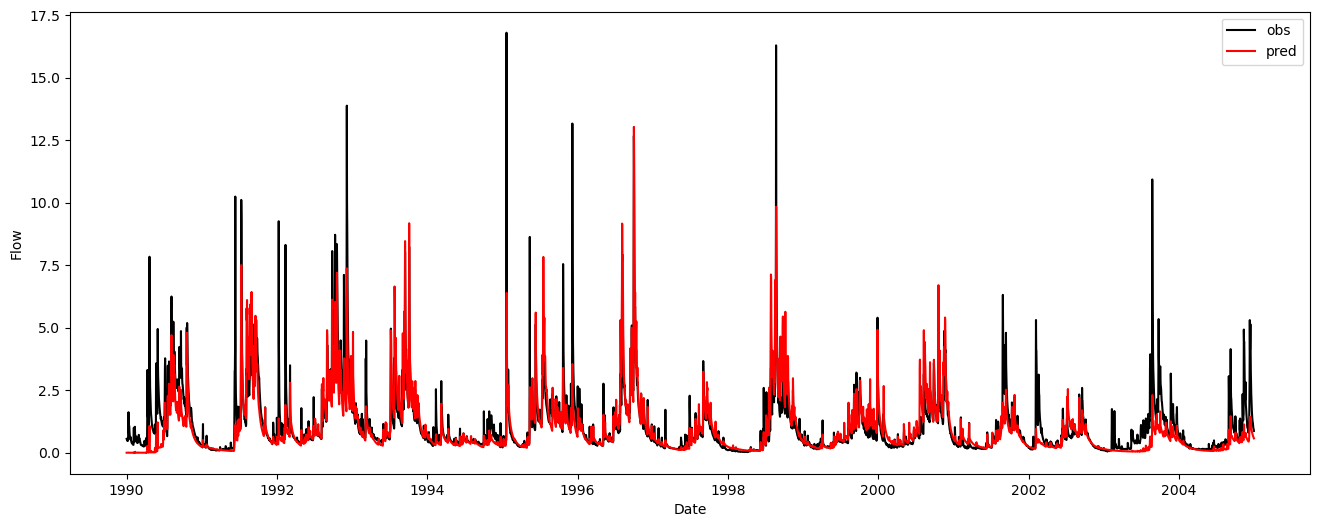

In [37]:
flow_pred_calib, _ = evaluate(model, date_calib,  et_calib, prcp_calib, flow_calib)


NSE: 0.723963484097597
MSE: 0.6563


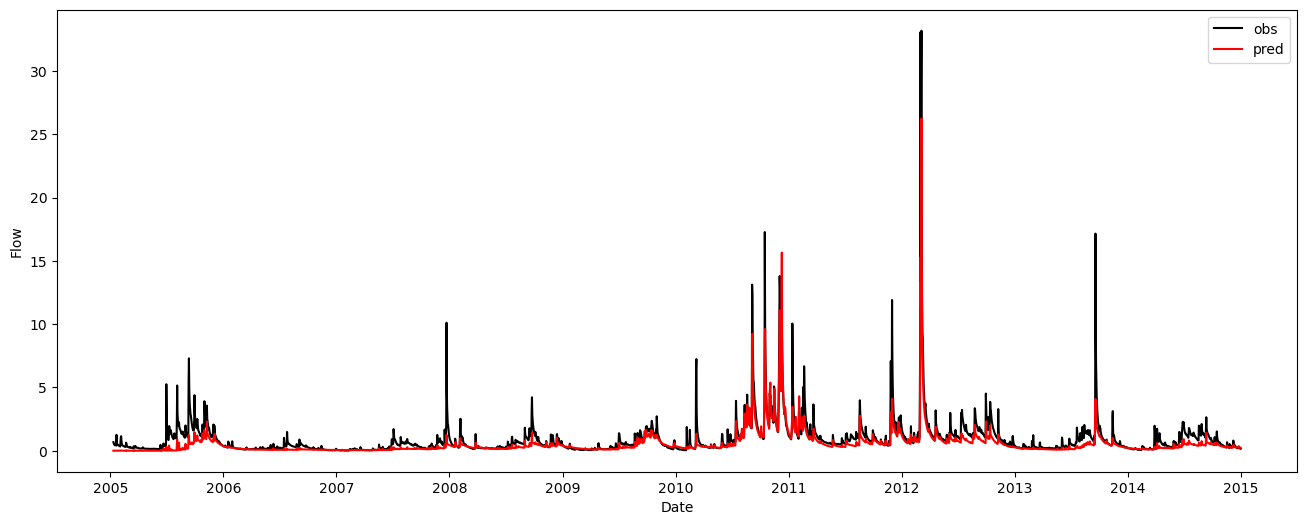

In [41]:
# Evaluate on unseen data
prcp_holdout = holdout_data.loc[:, 'daily_rain'].values
et_holdout= holdout_data.loc[:, 'et_short_crop'].values
flow_holdout = holdout_data.loc[:, 'flow_ml'].values
date_holdout = holdout_data.loc[:, 'date'].values

flow_pred_holdout, flow_holdout = evaluate(model, date_holdout[10:],  et_holdout[10:], prcp_holdout[10:], flow_holdout[10:])


In [39]:
np.savetxt('../../results/cotter_gr4j_val.txt', flow_pred_holdout)

In [40]:
np.savetxt('../../results/cotter_holdout.txt', flow_holdout)